In [1]:
import yaml
 
try:
    with open("../config.yaml", "r") as file:
        config = yaml.safe_load(file)
except:
    print("Yaml configuration file not found!")

In [4]:
import pandas as pd

df = pd.read_csv("../data/clean/alzheimers_top5.csv")
df

,FunctionalAssessment,ADL,MemoryComplaints,MMSE,BehavioralProblems,Diagnosis
0,6.518877,1.725883,0,21.463532,0,0
1,7.118696,2.592424,0,20.613267,0,0
2,5.895077,7.119548,0,7.356249,0,0
3,8.965106,6.481226,0,13.991127,1,0
4,6.045039,0.014691,0,13.517609,0,0
...,...,...,...,...,...,...
2144,0.238667,4.492838,0,1.201190,0,1
2145,8.687480,9.204952,0,6.458060,1,1
2146,1.972137,5.036334,0,17.011003,0,1
2147,5.173891,3.785399,0,4.030491,0,1


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt

Baseline Accuracy (using knn.score): 94.19%

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95       267
           1       0.94      0.90      0.92       163

    accuracy                           0.94       430
   macro avg       0.94      0.93      0.94       430
weighted avg       0.94      0.94      0.94       430



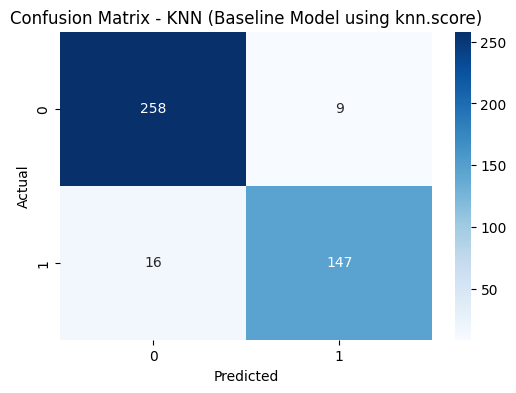

In [18]:
#KNN

# 1. Separate features (X) and target (y)
X = df.drop(columns=["Diagnosis"])
y = df["Diagnosis"]
# 2. Split data into training and testing sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)
# 3. Standardize the features (important for KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# 4. Initialize a simple KNN model
knn = KNeighborsClassifier(n_neighbors=5)
# 5. Train the model
knn.fit(X_train_scaled, y_train)
# 6. Evaluate accuracy using knn.score (instead of accuracy_score)
accuracy = knn.score(X_test_scaled, y_test)
print(f"Baseline Accuracy (using knn.score): {accuracy * 100:.2f}%")
# 7. Generate predictions for detailed metrics
y_pred = knn.predict(X_test_scaled)
# 8. Show detailed performance report
print("\nClassification Report:\n", classification_report(y_test, y_pred))
# 9. Display confusion matrix as a heatmap
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - KNN (Baseline Model using knn.score)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Cross-Validation Scores: [0.93023256 0.9244186  0.9127907  0.92151163 0.89504373]
Mean CV Accuracy: 0.9167994440301037
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best Parameters Found: {'metric': 'manhattan', 'n_neighbors': 18, 'weights': 'distance'}
Best Cross-Validation Accuracy: 0.9278561258390399

Test Accuracy: 0.9558139534883721

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96       267
           1       0.96      0.93      0.94       163

    accuracy                           0.96       430
   macro avg       0.96      0.95      0.95       430
weighted avg       0.96      0.96      0.96       430



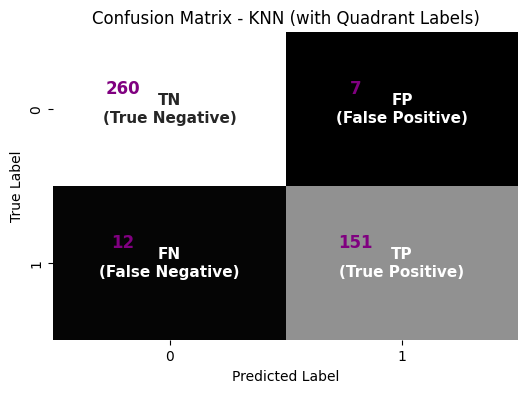

In [19]:
# 3. Separate features and target
X = df.drop(columns=["Diagnosis"])
y = df["Diagnosis"]
# 4. Split data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)
# 5. Standardize features (important for KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# ================================================
# STEP 1 — Cross-Validation (5 folds)
# ================================================
# Initialize a simple KNN model
knn = KNeighborsClassifier(n_neighbors=5)
# Perform 5-fold cross-validation
cv_scores = cross_val_score(knn, X_train_scaled, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
# ================================================
# STEP 2 — Grid Search for Hyperparameter Optimization
# ================================================
# Define parameter grid
param_grid = {
    'n_neighbors': range(3, 21),         # number of neighbors
    'weights': ['uniform', 'distance'],  # how to weight neighbors
    'metric': ['euclidean', 'manhattan'] # distance metrics
}
# Configure Grid Search with 5-fold CV
grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
# Train Grid Search
grid.fit(X_train_scaled, y_train)
# Display best parameters and best CV score
print("\nBest Parameters Found:", grid.best_params_)
print("Best Cross-Validation Accuracy:", grid.best_score_)
# ================================================
# STEP 3 — Evaluate Tuned Model on Test Set
# ================================================
# Retrieve best model
best_knn = grid.best_estimator_
# Predict on test data
y_pred = best_knn.predict(X_test_scaled)
# Evaluate performance
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Create labeled annotations for each cell
labels = [
    ["TN\n(True Negative)", "FP\n(False Positive)"],
    ["FN\n(False Negative)", "TP\n(True Positive)"]
]
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=labels, fmt='', cmap="grey", cbar=False, annot_kws={"fontsize":11, "weight":"bold"})
plt.title("Confusion Matrix - KNN (with Quadrant Labels)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
# Optional: Show numeric values on top of text
for i in range(2):
    for j in range(2):
        plt.text(j + 0.3, i + 0.3, f"\n{cm[i, j]}", color="purple", ha='center', va='center', fontsize=12, weight="bold")
plt.show()